# Experiment

## Install Python dependencies

In [4]:
!pip install onnx onnxruntime seaborn tf2onnx

  Obtaining dependency information for onnxruntime from https://files.pythonhosted.org/packages/60/ce/be4152da5c1030ab5a159a4a792ed9abad6ba498d79ef0aeba593ff7b5bf/onnxruntime-1.19.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for tf2onnx from https://files.pythonhosted.org/packages/3f/48/826db3d02645d84e7ee5d5ce8407f771057d40fe224d9c3e89536674ccef/tf2onnx-1.16.1-py3-none-any.whl.metadata
  Obtaining dependency information for coloredlogs from https://files.pythonhosted.org/packages/a7/06/3d6badcf13db419e25b07041d9c7b4a2c331d3f4e7134445ec5df57714cd/coloredlogs-15.0.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2dbd0ad4182ef2d53488b

Import the dependencies for the model training code:

In [2]:
!pip install keras tensorflow scikit-learn



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import tf2onnx
import onnx
import pickle
from pathlib import Path

2024-09-12 11:28:30.017432: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 11:28:30.021765: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 11:28:30.034701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 11:28:30.061816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 11:28:30.067985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 11:28:30.084021: I tensorflow/core/platform/cpu_feature_gu

## Load the CSV data

The CSV data that you use to train the model contains the following fields:

* **distancefromhome** - The distance from home where the transaction happened.
* **distancefromlast_transaction** - The distance from the last transaction that happened.
* **ratiotomedianpurchaseprice** - The ratio of purchased price compared to median purchase price.
* **repeat_retailer** - If it's from a retailer that already has been purchased from before.
* **used_chip** - If the credit card chip was used.
* **usedpinnumber** - If the PIN number was used.
* **online_order** - If it was an online order.
* **fraud** - If the transaction is fraudulent.

In [4]:
Data = pd.read_csv('data/card_transdata.csv')
Data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [5]:
# Set the input (X) and output (Y) data. 
# The only output data is whether it's fraudulent. All other fields are inputs to the model.

X = Data.drop(columns = ['repeat_retailer','distance_from_home', 'fraud'])
y = Data['fraud']

# Split the data into training and testing sets so you have something to test the trained model with.

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle = False)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Scale the data to remove mean and have unit variance. The data will be between -1 and 1, which makes it a lot easier for the model to learn than random (and potentially large) values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values)

Path("artifact").mkdir(parents=True, exist_ok=True)
with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)
with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

#changed eder
#from sklearn.utils import class_weight

#class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weights = {int(i): class_weights[i] for i in np.unique(y_train)}


## Build the model

The model is a simple, fully-connected, deep neural network, containing three hidden layers and one output layer.

In [6]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation

#eder changed the model here
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593 (10.13 KB)

 Trainable params: 2,465 (9.63 KB)

 Non-trainable params: 128 (512.00 B)

## Train the model

Training a model is often the most time-consuming part of the machine learning process.  Large models can take multiple GPUs for days.  Expect the training on CPU for this very simple model to take a minute or more.

In [7]:
# Train the model and get performance
import os

epochs = 2

#another change eder (From chat gpt)

# Ensure y_train is a NumPy array
y_train = y_train.values  # Convert to NumPy array if it's a pandas Series

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {int(cls): weight for cls, weight in zip(np.unique(y_train), class_weights)}



history = model.fit(X_train, y_train, epochs=epochs, \
                    validation_data=(scaler.transform(X_val.values),y_val), \
                    verbose = True, class_weight = class_weights)
print("Training of model is complete")

Epoch 1/2
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.8954 - loss: 0.2907 - val_accuracy: 0.9314 - val_loss: 0.2457
Epoch 2/2
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9472 - loss: 0.2348 - val_accuracy: 0.9498 - val_loss: 0.2172
Training of model is complete


## Save the model file

In [8]:
# Save the model as ONNX for easy use of ModelMesh
#model_proto, _ = tf2onnx.convert.from_keras(model)
#os.makedirs("models/fraud/1", exist_ok=True)
#onnx.save(model_proto, "models/fraud/1/model.onnx")
import tensorflow as tf
# Wrap the model in a `tf.function`
@tf.function(input_signature=[tf.TensorSpec([None, X_train.shape[1]], tf.float32)])
def model_fn(x):
    return model(x)

# Convert the Keras model to ONNX
model_proto, _ = tf2onnx.convert.from_function(
    model_fn, 
    input_signature=[tf.TensorSpec([None, X_train.shape[1]], tf.float32)]
)
os.makedirs("models/fraud/1", exist_ok=True)
onnx.save(model_proto, "models/fraud/1/model.onnx")

I0000 00:00:1726140660.067501     616 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-09-12 11:31:00.067726: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1726140660.192290     616 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-09-12 11:31:00.192513: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


## Confirm the model file was created successfully

The output should include the model name, size, and date. 

In [9]:
! ls -alRh ./models/

./models/:
total 12K
drwxr-sr-x.  3 1000810000 1000810000 4.0K Sep 12 11:31 .
drwxr-sr-x. 13 1000810000 1000810000 4.0K Sep 12 11:31 ..
drwxr-sr-x.  3 1000810000 1000810000 4.0K Sep 12 11:31 fraud

./models/fraud:
total 12K
drwxr-sr-x. 3 1000810000 1000810000 4.0K Sep 12 11:31 .
drwxr-sr-x. 3 1000810000 1000810000 4.0K Sep 12 11:31 ..
drwxr-sr-x. 2 1000810000 1000810000 4.0K Sep 12 11:31 1

./models/fraud/1:
total 24K
drwxr-sr-x. 2 1000810000 1000810000 4.0K Sep 12 11:31 .
drwxr-sr-x. 3 1000810000 1000810000 4.0K Sep 12 11:31 ..
-rw-r--r--. 1 1000810000 1000810000  13K Sep 12 11:31 model.onnx


## Test the model

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import onnxruntime as rt

Load the test data and scaler:

In [11]:
with open('artifact/scaler.pkl', 'rb') as handle:
    scaler = pickle.load(handle)
with open('artifact/test_data.pkl', 'rb') as handle:
    (X_test, y_test) = pickle.load(handle)

Create an ONNX inference runtime session and predict values for all test inputs:

In [14]:
sess = rt.InferenceSession("models/fraud/1/model.onnx", providers=rt.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], {input_name: scaler.transform(X_test.values).astype(np.float32)}) 
y_pred_temp = np.asarray(np.squeeze(y_pred_temp[0]))
threshold = 0.95
y_pred = np.where(y_pred_temp > threshold, 1,0)

Show the results:

Accuracy: 0.97636


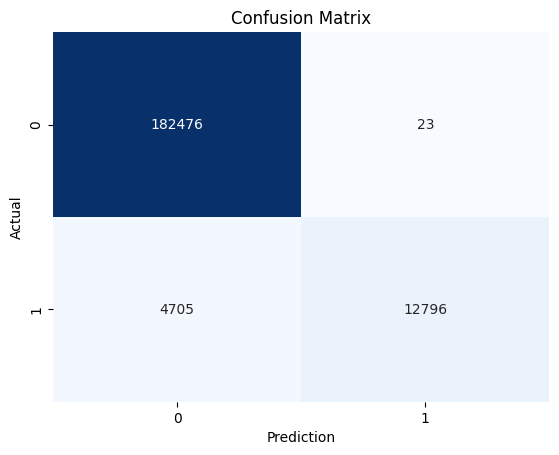

In [15]:
accuracy = np.sum(np.asarray(y_test) == y_pred) / len(y_pred)
print("Accuracy: " + str(accuracy))

c_matrix = confusion_matrix(np.asarray(y_test),y_pred)
ax = sns.heatmap(c_matrix, annot=True,fmt='d', cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

## Example: Is Sally's transaction likely to be fraudulent?

Here is the order of the fields from Sally's transaction details:
* distance_from_last_transaction
* ratio_to_median_price
* used_chip 
* used_pin_number
* online_order 

In [2]:
sally_transaction_details = [
    [0.3111400080477545,
    1.9459399775518593, 
    1.0, 
    0.0, 
    0.0]
    ]

prediction = sess.run([output_name], {input_name: scaler.transform(sally_transaction_details).astype(np.float32)})

print("Is Sally's transaction predicted to be fraudulent? (true = YES, false = NO) ")
print(np.squeeze(prediction) > threshold)

print("How likely was Sally's transaction to be fraudulent? ")
print("{:.5f}".format(np.squeeze(prediction)) + "%")

NameError: name 'sess' is not defined

In [6]:
import onnx
model = onnx.load("models/fraud/1/model.onnx")
for input in model.graph.input:
    print(input.name)

x
